This note book is about price forecasting using time series method for Yes Energy.

Import necessary packages.

In [5]:
import numpy as np
import pandas as pd
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from math import sqrt
from statsmodels.tsa.stattools import acf

**Part 1**: Data cleansing and file combination

Investigation: Here we read and investigate the data files.
We can find the record counts are different between the files, because the 'tokyo_electricity_prices' is half-hourly, and other files are hourly. Besides, there are some missing values need to be filled.

In [2]:
# float display setting
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# a list of filenames
files = ['tokyo_electricity_prices', 'tokyo_electricity_demand', 'tokyo_solar_generation', 'tokyo_wind_generation', 'tokyo_weather']
dataframes = {}

# load files into a dictionary for iteration and summary the data structure
for file in files:
    dataframes[file] = pd.read_csv(f"{file}.csv", header=0)

for name, df in dataframes.items():
    df_first = df.iloc[:, 2:].copy()    # to skip the same identifiers, date and time in each file
    summary = {
        'Count': df_first.count(),
        'Min (-99 excluded)': df_first.apply(lambda x: x[x != -99].min()).values,
        'Q1 (25th, -99 excluded)': df_first.apply(lambda x: x[x != -99].quantile(0.25)).values,
        'Mean (-99 excluded)': df_first.apply(lambda x: x[x != -99].mean()).values,
        'Median': df_first.median(),
        'Q3 (75th, -99 excluded)': df_first.apply(lambda x: x[x != -99].quantile(0.75)).values,
        'Max': df_first.max(),
        'Missing value count (-99)': (df_first == -99).sum()
    }
    df_summary = pd.DataFrame(summary)
    print(f"Summary for {name} (Before replacing -99):")
    display(df_summary)

Summary for tokyo_electricity_prices (Before replacing -99):


,Count,Min (-99 excluded),"Q1 (25th, -99 excluded)",Mean (-99 excluded),Median,"Q3 (75th, -99 excluded)",Max,Missing value count (-99)
price_act,59856,0.01,9.36,17.19,13.42,20.01,252.00,2


Summary for tokyo_electricity_demand (Before replacing -99):


,Count,Min (-99 excluded),"Q1 (25th, -99 excluded)",Mean (-99 excluded),Median,"Q3 (75th, -99 excluded)",Max,Missing value count (-99)
load_act,29928,1855,2664.00,3194.92,3116.00,3610.00,5930,0


Summary for tokyo_solar_generation (Before replacing -99):


,Count,Min (-99 excluded),"Q1 (25th, -99 excluded)",Mean (-99 excluded),Median,"Q3 (75th, -99 excluded)",Max,Missing value count (-99)
load_act,29928,0.00,0.00,267.03,4.00,449.00,1635.33,30


Summary for tokyo_wind_generation (Before replacing -99):


,Count,Min (-99 excluded),"Q1 (25th, -99 excluded)",Mean (-99 excluded),Median,"Q3 (75th, -99 excluded)",Max,Missing value count (-99)
load_act,29928,0.00,4.00,9.08,7.00,13.00,41.00,4


Summary for tokyo_weather (Before replacing -99):


,Count,Min (-99 excluded),"Q1 (25th, -99 excluded)",Mean (-99 excluded),Median,"Q3 (75th, -99 excluded)",Max,Missing value count (-99)
tempc,29928,-3.20,9.50,16.38,16.40,23.00,37.20,11
cloud8,29928,0.00,2.00,4.96,6.00,7.00,8.00,7
windmps,29928,0.00,1.00,2.73,3.00,4.00,12.00,12
wdir,29928,0.00,130.00,201.44,180.00,320.00,360.00,12
rainmm,29928,0.00,0.00,0.19,0.00,0.04,14.25,7
humid,29928,11.00,53.00,68.24,69.00,85.00,100.00,11
radjcm2,29928,0.00,0.00,59.39,1.00,101.00,366.00,139


Deal with missing values: We try to replace the missing value using interpolation (liner). The overall data structure, mean, median, Q1 and Q3 are almost remained, which means the liner interpolation is a good way to replace the missing value.

In [3]:
# this time, replace the missing value and summarise the structure again for comparison
for name, df in dataframes.items():
    df_second = df.iloc[:, 2:].copy()
    df_second.replace(-99, np.nan, inplace=True)
    df_second = df_second.interpolate(method='linear', axis=0, limit_direction='both')
    summary = {
        'Count': df_second.count(),
        'Min (-99 excluded)': df_second.apply(lambda x: x[x != -99].min()).values,
        'Q1 (25th, -99 excluded)': df_second.apply(lambda x: x[x != -99].quantile(0.25)).values,
        'Mean (-99 excluded)': df_second.apply(lambda x: x[x != -99].mean()).values,
        'Median': df_second.median(),
        'Q3 (75th, -99 excluded)': df_second.apply(lambda x: x[x != -99].quantile(0.75)).values,
        'Max': df_second.max(),
        'Missing value count (-99)': (df_second == -99).sum()
    }
    df_summary = pd.DataFrame(summary)
    print(f"Summary for {name}:")
    display(df_summary)

Summary for tokyo_electricity_prices:


,Count,Min (-99 excluded),"Q1 (25th, -99 excluded)",Mean (-99 excluded),Median,"Q3 (75th, -99 excluded)",Max,Missing value count (-99)
price_act,59856,0.01,9.36,17.19,13.42,20.01,252.00,0


Summary for tokyo_electricity_demand:


,Count,Min (-99 excluded),"Q1 (25th, -99 excluded)",Mean (-99 excluded),Median,"Q3 (75th, -99 excluded)",Max,Missing value count (-99)
load_act,29928,1855,2664.00,3194.92,3116.00,3610.00,5930,0


Summary for tokyo_solar_generation:


,Count,Min (-99 excluded),"Q1 (25th, -99 excluded)",Mean (-99 excluded),Median,"Q3 (75th, -99 excluded)",Max,Missing value count (-99)
load_act,29928,0.00,0.00,266.89,4.00,449.00,1635.33,0


Summary for tokyo_wind_generation:


,Count,Min (-99 excluded),"Q1 (25th, -99 excluded)",Mean (-99 excluded),Median,"Q3 (75th, -99 excluded)",Max,Missing value count (-99)
load_act,29928,0.00,4.00,9.08,7.00,13.00,41.00,0


Summary for tokyo_weather:


,Count,Min (-99 excluded),"Q1 (25th, -99 excluded)",Mean (-99 excluded),Median,"Q3 (75th, -99 excluded)",Max,Missing value count (-99)
tempc,29928,-3.20,9.50,16.38,16.40,23.00,37.20,0
cloud8,29928,0.00,2.00,4.96,6.00,7.00,8.00,0
windmps,29928,0.00,1.00,2.73,3.00,4.00,12.00,0
wdir,29928,0.00,130.00,201.44,180.00,320.00,360.00,0
rainmm,29928,0.00,0.00,0.19,0.00,0.04,14.25,0
humid,29928,11.00,53.00,68.24,69.00,85.00,100.00,0
radjcm2,29928,0.00,0.00,59.11,1.00,101.00,366.00,0


File combination: Finally, we combine data together, with the missing data replaced with  for modeling.

In [4]:
# define a function for data cleasning and combination

def preprocess_data(file_list, main_file):
    # create a dictionary to store data
    results = {}

    # load files into a dictionary for iteration and summary the data structure
    for file in file_list:
        results[file] = pd.read_csv(f"{file}.csv", header=0)
    
    # merge data together
    for name, df in results.items():
        df.replace(-99, np.nan, inplace=True)
        df = df.interpolate(method='linear', axis=0, limit_direction='both')
        if name != main_file:
            df_final = pd.merge(df_final, df, on=['date', 'time'], how='left')
            df_final.ffill(inplace = True)
        else:
            df_final = results[main_file]
    
    # preprocess date variables
    df_final['time'] = df_final['time'].apply(lambda x: f"{x:04d}")
    df_final['datetime'] = pd.to_datetime(df_final['date'].astype(str) + ' ' + df_final['time'].str[:2] + ':' + df_final['time'].str[2:], format='%Y%m%d %H:%M')
    df_final.set_index('datetime', inplace=True)
    df_final.drop(columns=['time','date'], inplace=True)

    return df_final

# call the function
df_final = preprocess_data(files, files[0])

# save dataset locally
df_final.to_csv('tokyo_electricity_final_dataset_half_hourly.csv')

# generate structure for final dataset
summary = {
        'Min': df_final.min(),
        'Q1 (25th)': df_final.quantile(0.25),
        'Mean': df_final.mean(),
        'Median': df_final.median(),
        'Q3 (75th)': df_final.quantile(0.75),
        'Max': df_final.max()
    }
df_summary = pd.DataFrame(summary)
print(f"Summary for final dataset:")
display(df_summary)

Summary for final dataset:


,Min,Q1 (25th),Mean,Median,Q3 (75th),Max
price_act,0.01,9.36,17.19,13.42,20.01,252.00
load_act_x,1855.00,2664.00,3194.92,3116.00,3610.00,5930.00
load_act_y,0.00,0.00,266.89,4.00,449.00,1635.33
load_act,0.00,4.00,9.08,7.00,13.00,41.00
tempc,-3.20,9.50,16.38,16.40,23.00,37.20
cloud8,0.00,2.00,4.96,6.00,7.00,8.00
windmps,0.00,1.00,2.73,3.00,4.00,12.00
wdir,0.00,130.00,201.44,180.00,320.00,360.00
rainmm,0.00,0.00,0.19,0.00,0.04,14.25
humid,11.00,53.00,68.24,69.00,85.00,100.00


**Part 2**: Feature Engineering

We will observe the variables and the relationship between each other. To better investigate, we try to use a dashboard to interactively view the results.

In [5]:
# initialize a dashboard
app = Dash(__name__)

# get the variable name list
variable_columns = df_final.columns.tolist()

# set the dashboard layout
app.layout = html.Div([
    html.H3('Select a variable you want to investigate', style={'display': 'inline-block', 'verticalAlign': 'middle', 'margin': '0px'}),
    dcc.Dropdown(id='variable-dropdown', options=[{'label': col, 'value': col} for col in variable_columns], value=variable_columns[0], style={'width': '50%', 'display': 'inline-block', 'verticalAlign': 'middle', 'margin': '0px'}),
    html.Div([
        html.Div([html.H3('Correlation', style={'margin': '2px 10px 11px 10px', 'textAlign': 'center'}), 
                  html.Table(id='correlation-table', style={'display': 'flex', 'justify-content': 'center'})], 
                  style={'height': '280px', 'width': '24%', 'display': 'inline-block', 'verticalAlign': 'top', 'border': '1px solid #ccc'}),
        html.Div([html.H3('Histogram', style={'margin': '2px 10px', 'textAlign': 'center'}), 
                  dcc.Graph(id='histogram', style={'height': '250px', 'margin': '0px', 'display': 'flex', 'justify-content': 'center'}, config={'displayModeBar': False})], 
                  style={'height': '280px', 'width': '40%', 'display': 'inline-block', 'verticalAlign': 'top', 'border': '1px solid #ccc'}),
        html.Div([html.H3('Structure Summary', style={'margin': '2px 10px 11px 10px', 'textAlign': 'center'}), 
                  html.Table(id='statistics-table', style={'display': 'flex', 'justify-content': 'center'})], 
                  style={'height': '280px', 'width': '23%', 'display': 'inline-block', 'verticalAlign': 'top', 'border': '1px solid #ccc'}),
    ], style={'margin': '0px'}),
    html.Div([
        html.Div([html.H3('Weekly ACF', style={'margin': '2px 10px', 'textAlign': 'center'}),
                  dcc.Graph(id='weekly_acf', style={'height': '250px', 'margin': '0px', 'display': 'flex', 'justify-content': 'center'}, config={'displayModeBar': False})], style={'height': '250px', 'width': '29%', 'display': 'inline-block', 'verticalAlign': 'top', 'border': '1px solid #ccc'}),
        html.Div([html.H3('Monthly ACF', style={'margin': '2px 10px', 'textAlign': 'center'}),
                  dcc.Graph(id='monthly_acf', style={'height': '250px', 'margin': '0px', 'display': 'flex', 'justify-content': 'center'}, config={'displayModeBar': False})], style={'height': '250px', 'width': '29%', 'display': 'inline-block', 'verticalAlign': 'top', 'border': '1px solid #ccc'}),
        html.Div([html.H3('Yearly ACF', style={'margin': '2px 10px', 'textAlign': 'center'}),
                  dcc.Graph(id='yearly_acf', style={'height': '250px', 'margin': '0px', 'display': 'flex', 'justify-content': 'center'}, config={'displayModeBar': False})], style={'height': '250px', 'width': '29%', 'display': 'inline-block', 'verticalAlign': 'top', 'border': '1px solid #ccc'}),
    ], style={'margin': '0px'}),
], style={'height': '600px', 'backgroundColor': 'white', 'font-family': 'Arial', 'padding': '10px'})

@app.callback(
    [Output('correlation-table', 'children'),
     Output('histogram', 'figure'),
     Output('statistics-table', 'children'),
     Output('weekly_acf', 'figure'),
     Output('monthly_acf', 'figure'),
     Output('yearly_acf', 'figure')],
    [Input('variable-dropdown', 'value')]
)
def update_charts(selected_variable):
    # corelation
    corr_matrix = df_final.corr()
    corr_with_selected = corr_matrix[[selected_variable]].drop(selected_variable)
    corr_table = html.Table([
        html.Tr([html.Th('Variable', style={'fontWeight': 'bold', 'border': '1px solid #ccc', 'textAlign': 'center'}),
                 html.Th('Correlation', style={'border': '1px solid #ccc', 'textAlign': 'center'})])
    ] + [
        html.Tr([html.Td(var, style={'fontWeight': 'bold', 'border': '1px solid #ccc', 'textAlign': 'center'}),
                 html.Td(f'{corr:.2f}', style={'border': '1px solid #ccc', 'textAlign': 'right'})])
        for var, corr in corr_with_selected[selected_variable].items()
    ], style={'borderCollapse': 'collapse'})

    # histgram chart
    hist_fig = px.histogram(df_final, x=selected_variable, nbins=30)
    hist_fig.update_layout(margin=dict(t=10, b=10, l=10, r=10))
    hist_fig.update_layout(xaxis_title_font=dict(size=11), yaxis_title_font=dict(size=11))

    # data structure
    max_val = df_final[selected_variable].max()
    q1_val = df_final[selected_variable].quantile(0.25)
    mean_val = df_final[selected_variable].mean()
    median_val = df_final[selected_variable].median()
    mode_val = df_final[selected_variable].mode()[0]
    q3_val = df_final[selected_variable].quantile(0.75)
    min_val = df_final[selected_variable].min()  
    
    stats_table = html.Table([
        html.Tr([html.Th('Statistic', style={'fontWeight': 'bold', 'border': '1px solid #ccc', 'textAlign': 'center'}),
                 html.Th('Value', style={'border': '1px solid #ccc', 'textAlign': 'center'})]),
        html.Tr([html.Td('Min', style={'fontWeight': 'bold', 'border': '1px solid #ccc', 'textAlign': 'center'}),
                 html.Td(f'{min_val:.2f}', style={'border': '1px solid #ccc', 'textAlign': 'right'})]),
        html.Tr([html.Td('Q1 (25th)', style={'fontWeight': 'bold', 'border': '1px solid #ccc', 'textAlign': 'center'}),
                 html.Td(f'{q1_val:.2f}', style={'border': '1px solid #ccc', 'textAlign': 'right'})]),
        html.Tr([html.Td('Mean', style={'fontWeight': 'bold', 'border': '1px solid #ccc', 'textAlign': 'center'}),
                 html.Td(f'{mean_val:.2f}', style={'border': '1px solid #ccc', 'textAlign': 'right'})]),
        html.Tr([html.Td('Median', style={'fontWeight': 'bold', 'border': '1px solid #ccc', 'textAlign': 'center'}),
                 html.Td(f'{median_val:.2f}', style={'border': '1px solid #ccc', 'textAlign': 'right'})]),
        html.Tr([html.Td('Mode', style={'fontWeight': 'bold', 'border': '1px solid #ccc', 'textAlign': 'center'}),
                 html.Td(f'{mode_val:.2f}', style={'border': '1px solid #ccc', 'textAlign': 'right'})]),
        html.Tr([html.Td('Q3 (75th)', style={'fontWeight': 'bold', 'border': '1px solid #ccc', 'textAlign': 'center'}),
                 html.Td(f'{q3_val:.2f}', style={'border': '1px solid #ccc', 'textAlign': 'right'})]),
        html.Tr([html.Td('Max', style={'fontWeight': 'bold', 'border': '1px solid #ccc', 'textAlign': 'center'}),
                 html.Td(f'{max_val:.2f}', style={'border': '1px solid #ccc', 'textAlign': 'right'})])
    ], style={'borderCollapse': 'collapse'})

    # weekly_acf
    weekly_acf_values = acf(df_final[selected_variable], nlags=336, fft=True)
    weekly_acf = go.Figure()
    weekly_acf.add_trace(go.Scatter(x=np.arange(len(weekly_acf_values)), y=weekly_acf_values, mode='lines+markers'))
    weekly_acf.update_layout(
        xaxis_title="Lag",
        yaxis_title="ACF",
        margin=dict(t=10, b=10, l=10, r=10),
        xaxis_title_font=dict(size=11), 
        yaxis_title_font=dict(size=11)
    )

    # monthly_acf
    monthly_acf_values = acf(df_final[selected_variable], nlags=1440, fft=True)
    monthly_acf = go.Figure()
    monthly_acf.add_trace(go.Scatter(x=np.arange(len(monthly_acf_values)), y=monthly_acf_values, mode='lines+markers'))
    monthly_acf.update_layout(
        xaxis_title="Lag",
        yaxis_title="ACF",
        margin=dict(t=10, b=10, l=10, r=10),
        xaxis_title_font=dict(size=11), 
        yaxis_title_font=dict(size=11)
    )

    # yearly_acf
    yearly_acf_values = acf(df_final[selected_variable], nlags=17520, fft=True)
    yearly_acf = go.Figure()
    yearly_acf.add_trace(go.Scatter(x=np.arange(len(yearly_acf_values)), y=yearly_acf_values, mode='lines+markers'))
    yearly_acf.update_layout(
        xaxis_title="Lag",
        yaxis_title="ACF",
        margin=dict(t=10, b=10, l=10, r=10),
        xaxis_title_font=dict(size=11), 
        yaxis_title_font=dict(size=11)
    )

    return corr_table, hist_fig, stats_table, weekly_acf, monthly_acf, yearly_acf

if __name__ == '__main__':
    app.run_server(debug=True)

From the observation, we get conclusion:
1) Y variable, actual electricity price, is relatively stable. It doesn't show some seasonal movement. But it does have outliers during 2021 Q1 and 2022 Q3.
2) High correlation X variables are: electricity demand (0.33), solar generation (-0.14), temperature (-0.13) and radiation (-0.12), and it seems easy to understand the relationship between these four variables and actual electricity price. Beside, these four variables all show explicit seasonal trend.
3) Other variables could be excluded in future modeling due to low relationship with electricity price.

Below, we add some seasonal features, hour, month, and season into the dataset to better capture the seasonal movements.
And then, we transform the feature scales, split the data into train and text sets, determine the look back length and create a call back function.

In [6]:
# define look back
look_back = 48 * 120

# Define target and selected features
feature_list = ['price_act', 'load_act_x', 'load_act_y', 'tempc', 'radjcm2']
df = df_final[feature_list].copy()

# Feature transformation
scalers = {}
for feature in feature_list:
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[feature] = scaler.fit_transform(df[[feature]])
    scalers[feature] = scaler


# Define a function to generate sequence data for LSTM model
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)].values)
        y.append(data.iloc[i + look_back].values)
    return np.array(X), np.array(y)

# Define train and test datasets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = X_train.reshape(X_train.shape[0], look_back, len(feature_list))
X_test = X_test.reshape(X_test.shape[0], look_back, len(feature_list))

In [7]:
print("X_train Shape-- ",X_train.shape)
print("y_train Shape-- ",y_train.shape)
print("X_test Shape-- ",X_test.shape)
print("y_test Shape-- ",y_test.shape)

X_train Shape--  (42124, 5760, 5)
y_train Shape--  (42124, 5)
X_test Shape--  (6212, 5760, 5)
y_test Shape--  (6212, 5)


In [8]:
# Create LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, len(feature_list)), kernel_regularizer=l2(0.005)))
model.add(LSTM(50, return_sequences=False, kernel_regularizer=l2(0.005)))
model.add(Dropout(0.2))
model.add(Dense(len(feature_list)))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test), shuffle=False, verbose=2)

# Save model
model.save('Tokyo_electricity_price_prediction_LSTM_02.keras')

d:\2024-2025 University of Canterbury MADS\DIGI405 Texts, Discourses & Data the Humanities\Exam\DIGI405\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/15
659/659 - 11928s - 18s/step - loss: 0.0543 - val_loss: 0.0323
Epoch 2/15
659/659 - 11709s - 18s/step - loss: 0.0108 - val_loss: 0.0374
Epoch 3/15
659/659 - 12710s - 19s/step - loss: 0.0096 - val_loss: 0.0369
Epoch 4/15
659/659 - 11634s - 18s/step - loss: 0.0087 - val_loss: 0.0364
Epoch 5/15
659/659 - 11187s - 17s/step - loss: 0.0081 - val_loss: 0.0357
Epoch 6/15
659/659 - 11090s - 17s/step - loss: 0.0077 - val_loss: 0.0339
Epoch 7/15
659/659 - 11246s - 17s/step - loss: 0.0074 - val_loss: 0.0335
Epoch 8/15
659/659 - 10828s - 16s/step - loss: 0.0071 - val_loss: 0.0335
Epoch 9/15
659/659 - 10448s - 16s/step - loss: 0.0070 - val_loss: 0.0340
Epoch 10/15
659/659 - 12250s - 19s/step - loss: 0.0068 - val_loss: 0.0336
Epoch 11/15
659/659 - 11324s - 17s/step - loss: 0.0067 - val_loss: 0.0334
Epoch 12/15
659/659 - 10263s - 16s/step - loss: 0.0066 - val_loss: 0.0332
Epoch 13/15
659/659 - 9651s - 15s/step - loss: 0.0065 - val_loss: 0.0326
Epoch 14/15
659/659 - 9242s - 14s/step - loss: 0

1317/1317 ━━━━━━━━━━━━━━━━━━━━ 1266s 961ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 150s 768ms/step
y_train_pred Shape--  (42124, 5)
y_test_pred Shape--  (6212, 5)
Train RMSE: 12.87
Test RMSE: 4.91


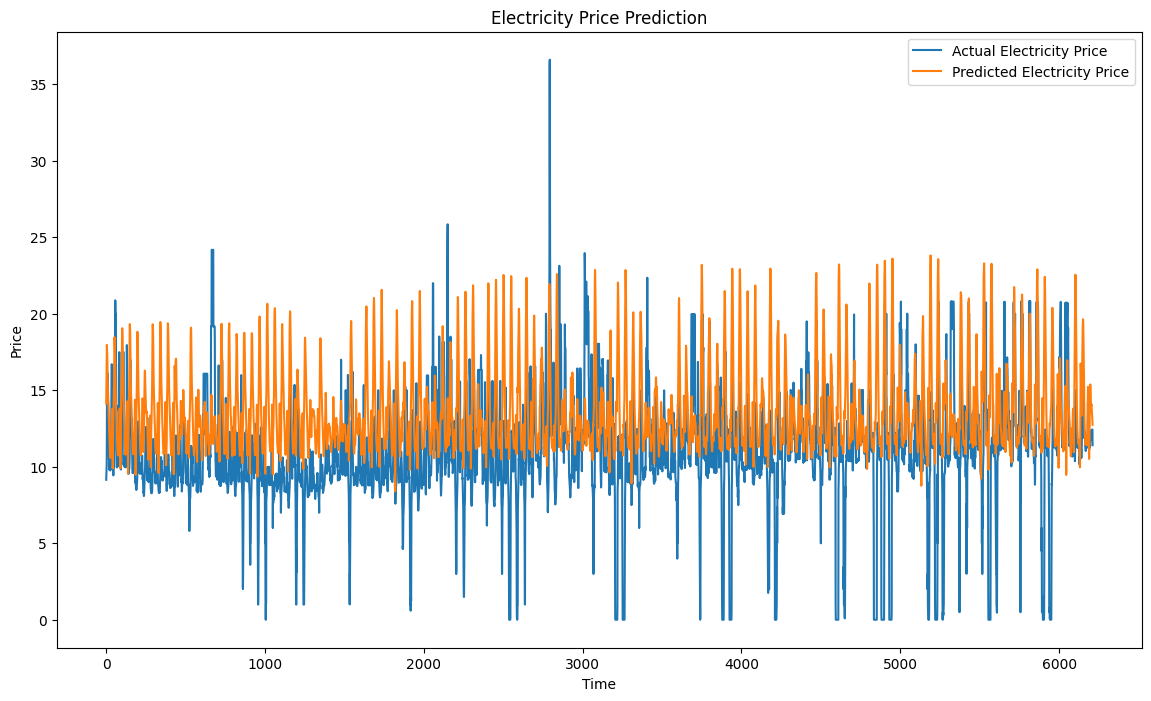

In [9]:
# 模型预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("y_train_pred Shape-- ",y_train_pred.shape)
print("y_test_pred Shape-- ",y_test_pred.shape)

# 逆归一化
y_train_pred = np.column_stack([scalers[feature].inverse_transform(y_train_pred[:, i].reshape(-1, 1)) for i, feature in enumerate(feature_list)])
y_test_pred = np.column_stack([scalers[feature].inverse_transform(y_test_pred[:, i].reshape(-1, 1)) for i, feature in enumerate(feature_list)])
y_train = np.column_stack([scalers[feature].inverse_transform(y_train[:, i].reshape(-1, 1)) for i, feature in enumerate(feature_list)])
y_test = np.column_stack([scalers[feature].inverse_transform(y_test[:, i].reshape(-1, 1)) for i, feature in enumerate(feature_list)])

# 计算RMSE
train_rmse = np.sqrt(np.mean((y_train[:, 0] - y_train_pred[:, 0]) ** 2))
test_rmse = np.sqrt(np.mean((y_test[:, 0] - y_test_pred[:, 0]) ** 2))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# 绘制电价对比的折线图
plt.figure(figsize=(14, 8))
plt.plot(y_test[:, 0], label='Actual Electricity Price')
plt.plot(y_test_pred[:, 0], label='Predicted Electricity Price')
plt.title('Electricity Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [10]:
model = load_model("Tokyo_electricity_price_prediction_LSTM_02.keras")

# 未来31天预测
future_steps = 31 * 48  # 未来31天，每天48个时间点
last_sequence = df[-look_back:].values  # 获取最近的look_back个数据作为初始输入
future_predictions = []

for _ in range(future_steps):
    # 对数据进行归一化
    last_sequence_df = pd.DataFrame(last_sequence, columns=feature_list)
    last_sequence_scaled = np.array([scalers[feature].transform(last_sequence_df[[feature]]) for feature in feature_list]).T
    last_sequence_scaled = last_sequence_scaled.reshape(1, look_back, len(feature_list))
    
    # 预测下一个时间点的所有变量
    next_pred = model.predict(last_sequence_scaled)
    
    # 存储预测结果
    future_predictions.append(next_pred[0])
    
    # 更新序列，将预测结果添加到最后
    next_sequence = np.append(last_sequence[1:], next_pred, axis=0)
    last_sequence = next_sequence

# 逆归一化未来预测结果
future_predictions = np.column_stack([scalers[feature].inverse_transform(np.array(future_predictions)[:, i].reshape(-1, 1)) for i, feature in enumerate(feature_list)])

# 输出未来预测结果
future_predictions_df = pd.DataFrame(future_predictions, columns=feature_list)
future_predictions_df.to_csv('future_electricity_price_predictions_02.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

C:\Users\86135\AppData\Local\Temp\ipykernel_25636\3383177493.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['20240601' '20240601' '20240601' ... '20240630' '20240630' '20240630']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_actual.iloc[:data_len, 0] = df_actual.iloc[:data_len, 0].astype(str)
C:\Users\86135\AppData\Local\Temp\ipykernel_25636\3383177493.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '30' '100' ... '2230' '2300' '2330']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_actual.iloc[:data_len, 1] = df_actual.iloc[:data_len, 1].astype(str)


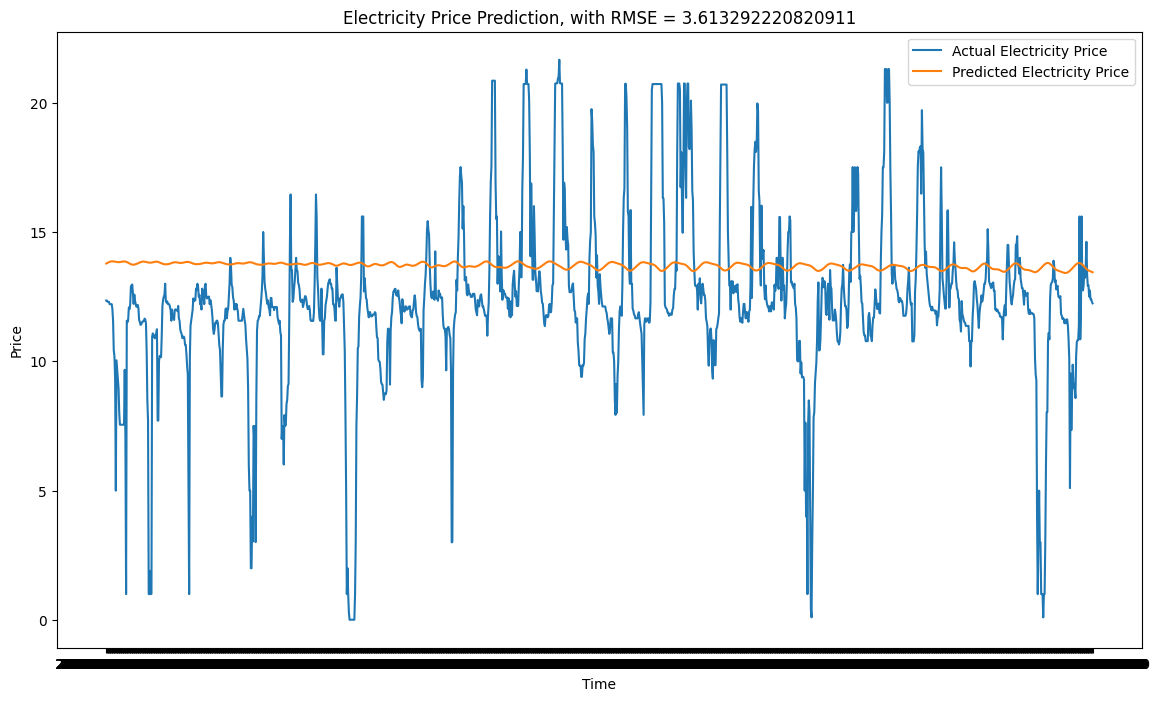

In [21]:
df_pred = pd.read_csv("future_electricity_price_predictions_02.csv", header=0)
df_actual = pd.read_csv("tokyo_june_electricity_prices.csv", header=0)

data_len = len(df_actual)

# Extract the necessary columns and data
price_pre_final = df_pred.iloc[:data_len, 0].values
price_actual_final = df_actual.iloc[:data_len, 2].values

# Ensure the relevant columns are strings
df_actual.iloc[:data_len, 0] = df_actual.iloc[:data_len, 0].astype(str)
df_actual.iloc[:data_len, 1] = df_actual.iloc[:data_len, 1].astype(str)

# Create datetime labels
df_actual['datetime'] = df_actual.iloc[:data_len, 0] + ' ' + df_actual.iloc[:data_len, 1].str[:2] + ':' + df_actual.iloc[:data_len, 1].str[2:]
date_label = df_actual['datetime'].values

# Calculate RMSE
final_rmse = np.sqrt(np.mean((price_pre_final - price_actual_final) ** 2))

# Plot the comparison line chart
plt.figure(figsize=(14, 8))
plt.plot(date_label, price_actual_final, label='Actual Electricity Price')
plt.plot(date_label, price_pre_final, label='Predicted Electricity Price')
plt.title(f'Electricity Price Prediction, with RMSE = {final_rmse}')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()